# Experiments Adversarial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import wandb

import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily


from adversarial_sb.adversarial_ipfp import AdversarialIPFPTrainer
from adversarial_sb.models import SimpleConditional, SimpleCritic, Conditional, Critic
from adversarial_sb.data import OneVariateDataset, MoonsDataset, CirclesDataset, LettersDataset, DigitsDataset
from adversarial_sb.utils import visualize_losses, visualize_sb, visualize_sb_images, visualize_gamma


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# One variate

## One mode

In [51]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = Normal(5, 1)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 120,
    'loader': dataloader,
    'gamma': 2.,
    'lr_disc': 1e-4, 
    'lr_gen': 4e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/120 [00:00<?, ?it/s]

gen Loss: 0.9602499842643738, disc Real Loss: 0.7983833596110343, disc Fake Loss: 0.4910175256431103


KeyboardInterrupt: 

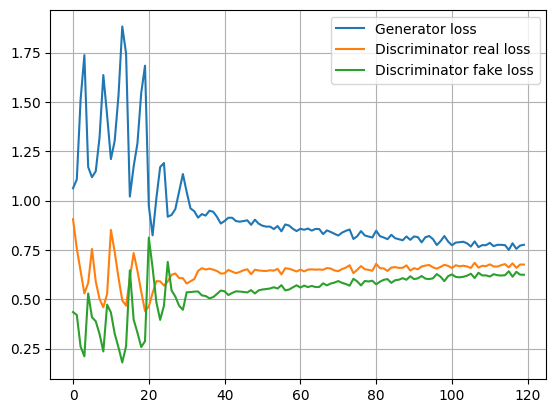

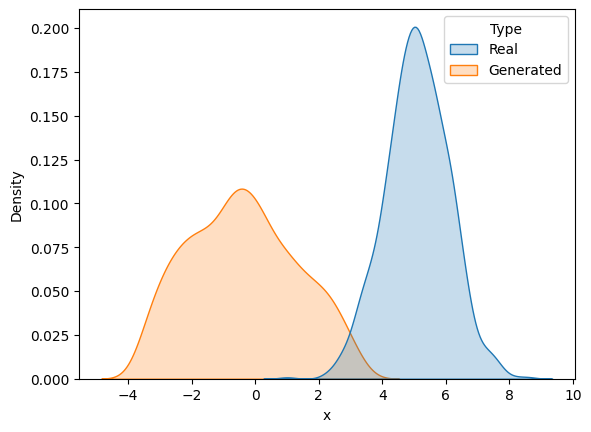

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 80
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.28373, disc_b_fixed: -0.23165, disc_b_training: -0.28385
Backward cond_p: 0.99555, disc_b_fixed: -0.31146, disc_b_training: 0.99489
Backward cond_p: 1.66834, disc_b_fixed: -0.26791, disc_b_training: 1.66830
Backward cond_p: 1.99952, disc_b_fixed: -0.17066, disc_b_training: 1.99945
Backward cond_p: 2.08107, disc_b_fixed: -0.11206, disc_b_training: 2.08110
Forward cond_q: 0.11598, disc_f_fixed: -0.56669, disc_f_training: 0.11587
Forward cond_q: 0.84751, disc_f_fixed: -0.33146, disc_f_training: 0.84384
Forward cond_q: 1.55291, disc_f_fixed: -0.27755, disc_f_training: 1.56263
Forward cond_q: 2.16279, disc_f_fixed: -0.20048, disc_f_training: 2.16318
Forward cond_q: 2.35231, disc_f_fixed: -0.21499, disc_f_training: 2.35589
======= Epoch 1 =======
Backward cond_p: 2.02779, disc_b_fixed: -0.31762, disc_b_training: 2.02537
Backward cond_p: 2.03402, disc_b_fixed: -0.17846, disc_b_training: 2.03334
Backward cond_p: 2.05206, disc_b_fixed: -0.16846, disc_

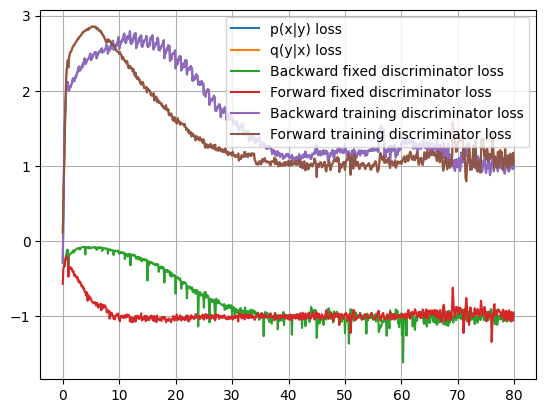

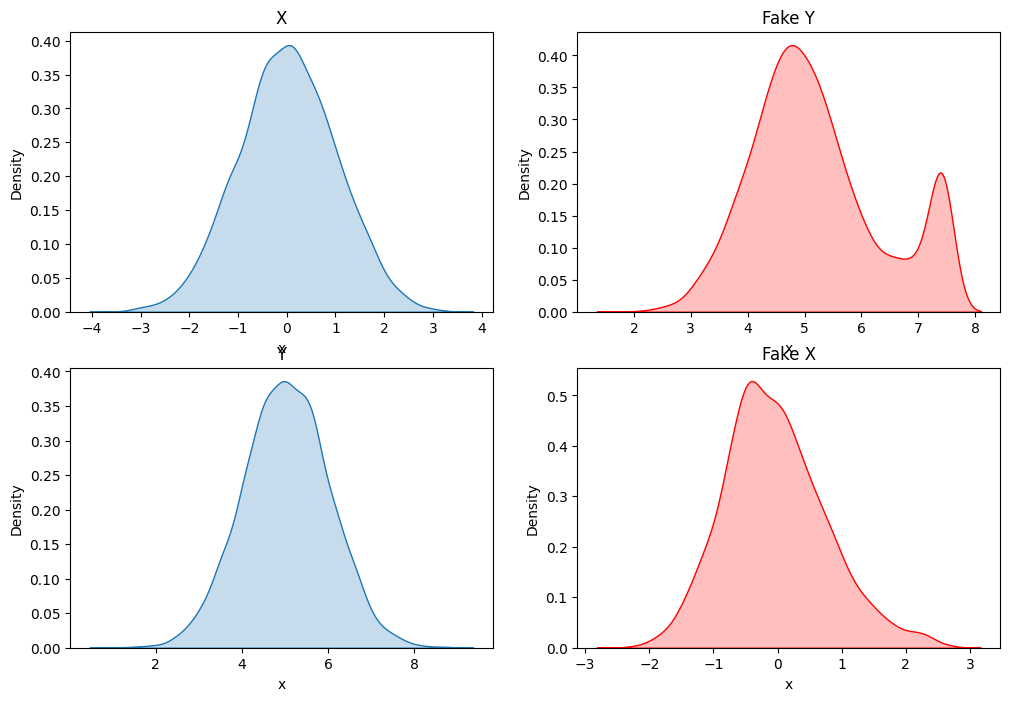

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

## Two modes

In [ ]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], dtype=torch.float)), 
    Normal(torch.tensor([20, -20], dtype=torch.float), torch.tensor([0.5, 0.5], dtype=torch.float))
)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 500,
    'loader': dataloader,
    'gamma': 10.,
    'lr_disc': 4e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'to'

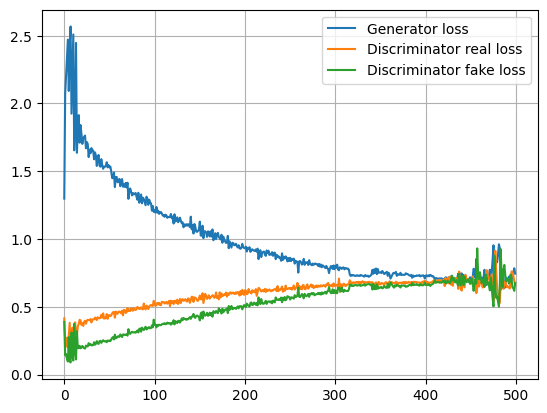

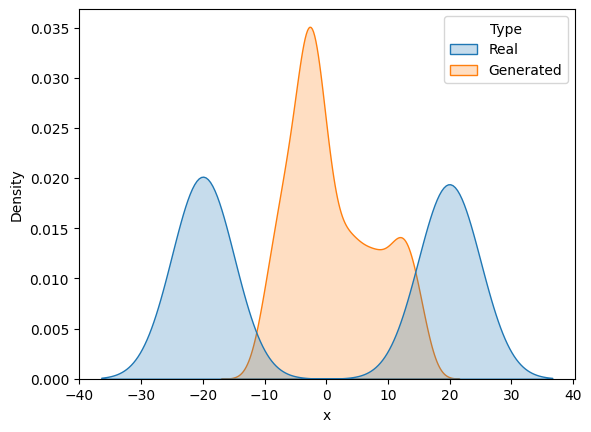

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 100
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.06882, disc_b_fixed: -0.38241, disc_b_training: 0.06879
Backward cond_p: 0.98676, disc_b_fixed: -0.71167, disc_b_training: 0.98666
Backward cond_p: 1.46368, disc_b_fixed: -0.64175, disc_b_training: 1.46345
Backward cond_p: 1.90606, disc_b_fixed: -0.48748, disc_b_training: 1.90594
Backward cond_p: 2.20280, disc_b_fixed: -0.28178, disc_b_training: 2.20246
Forward cond_q: 0.23523, disc_f_fixed: -0.52472, disc_f_training: 0.23874
Forward cond_q: 0.98505, disc_f_fixed: -0.78373, disc_f_training: 0.98823
Forward cond_q: 1.17830, disc_f_fixed: -0.69772, disc_f_training: 1.18277
Forward cond_q: 1.40036, disc_f_fixed: -0.55383, disc_f_training: 1.38292
Forward cond_q: 1.66683, disc_f_fixed: -0.34991, disc_f_training: 1.66477
======= Epoch 1 =======
Backward cond_p: 2.44365, disc_b_fixed: -0.23275, disc_b_training: 2.44257
Backward cond_p: 2.45283, disc_b_fixed: -0.23858, disc_b_training: 2.44970
Backward cond_p: 2.42948, disc_b_fixed: -0.23914, disc_b_

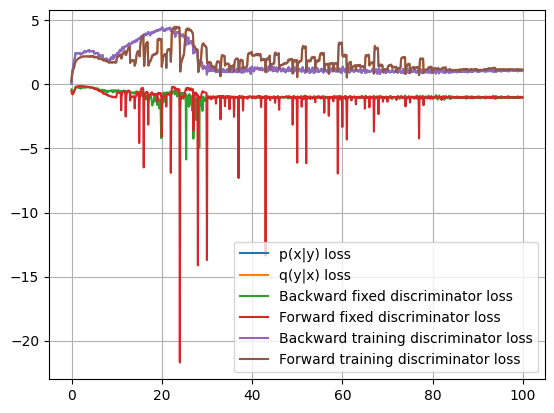

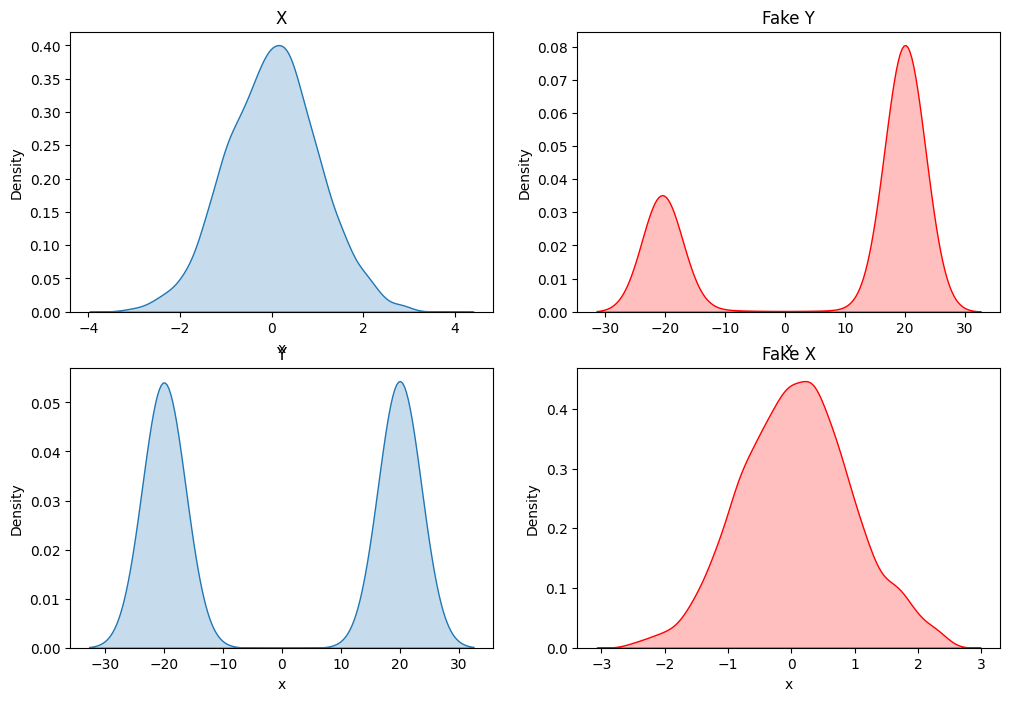

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 200
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.49170, disc_b_fixed: -0.56104, disc_b_training: 0.49169
Backward cond_p: 1.22511, disc_b_fixed: -0.81365, disc_b_training: 1.22504
Backward cond_p: 1.77094, disc_b_fixed: -0.65629, disc_b_training: 1.77089
Backward cond_p: 2.13138, disc_b_fixed: -0.46380, disc_b_training: 2.13141
Backward cond_p: 2.38483, disc_b_fixed: -0.29647, disc_b_training: 2.38470
Forward cond_q: 0.47034, disc_f_fixed: -0.59313, disc_f_training: 0.46639
Forward cond_q: 1.04808, disc_f_fixed: -0.73477, disc_f_training: 1.04901
Forward cond_q: 1.33726, disc_f_fixed: -0.63250, disc_f_training: 1.32820
Forward cond_q: 1.61513, disc_f_fixed: -0.35247, disc_f_training: 1.61887
Forward cond_q: 1.85230, disc_f_fixed: -0.12371, disc_f_training: 1.85272
======= Epoch 1 =======
Backward cond_p: 2.58021, disc_b_fixed: -0.17707, disc_b_training: 2.57999
Backward cond_p: 2.59820, disc_b_fixed: -0.16780, disc_b_training: 2.59848
Backward cond_p: 2.61076, disc_b_fixed: -0.17046, disc_b_

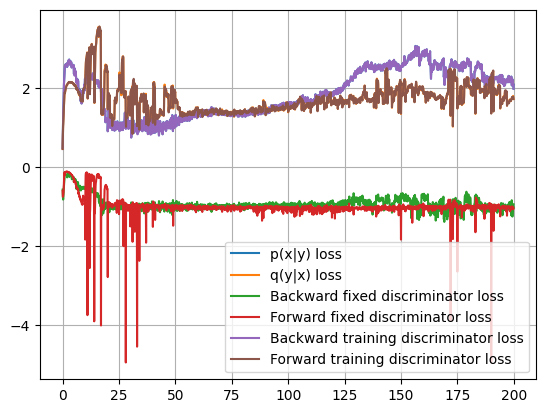

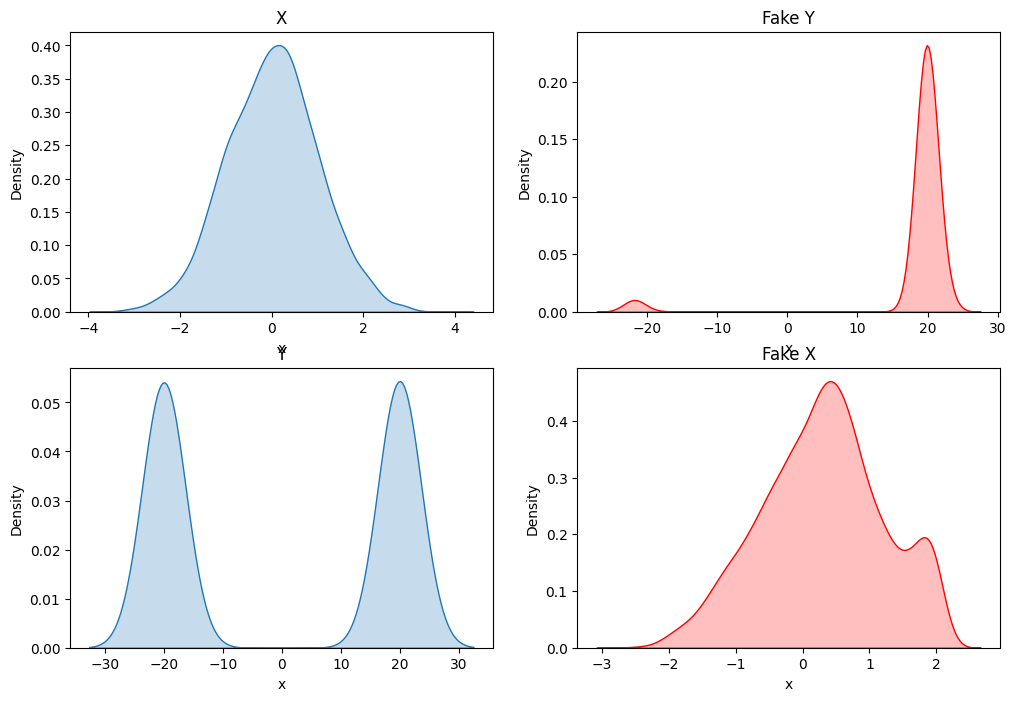

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 5e-5, 'backward': 5e-5},
    lr_gen={'forward': 2e-5, 'backward': 2e-5},
    # clip=0.001,
    device=device
)

epochs = 150
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.45783, disc_b_fixed: -0.64404, disc_b_training: 0.45779
Backward cond_p: 1.14569, disc_b_fixed: -0.77818, disc_b_training: 1.14552
Backward cond_p: 1.61054, disc_b_fixed: -0.51371, disc_b_training: 1.61032
Backward cond_p: 1.69893, disc_b_fixed: -0.46949, disc_b_training: 1.69885
Backward cond_p: 1.78507, disc_b_fixed: -0.41947, disc_b_training: 1.78381
Forward cond_q: 0.20120, disc_f_fixed: -0.50091, disc_f_training: 0.20646
Forward cond_q: 1.16796, disc_f_fixed: -0.72731, disc_f_training: 1.17349
Forward cond_q: 1.56670, disc_f_fixed: -0.55274, disc_f_training: 1.55276
Forward cond_q: 1.82607, disc_f_fixed: -0.23926, disc_f_training: 1.84101
Forward cond_q: 1.97565, disc_f_fixed: -0.15433, disc_f_training: 1.97312
======= Epoch 1 =======
Backward cond_p: 1.94056, disc_b_fixed: -0.66301, disc_b_training: 1.92121
Backward cond_p: 2.12373, disc_b_fixed: -0.46204, disc_b_training: 2.11118
Backward cond_p: 2.12963, disc_b_fixed: -0.48058, disc_b_

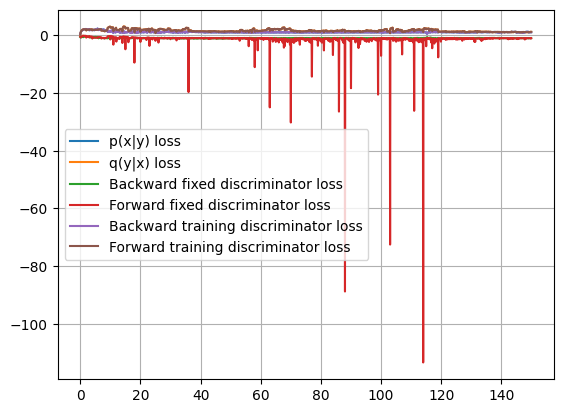

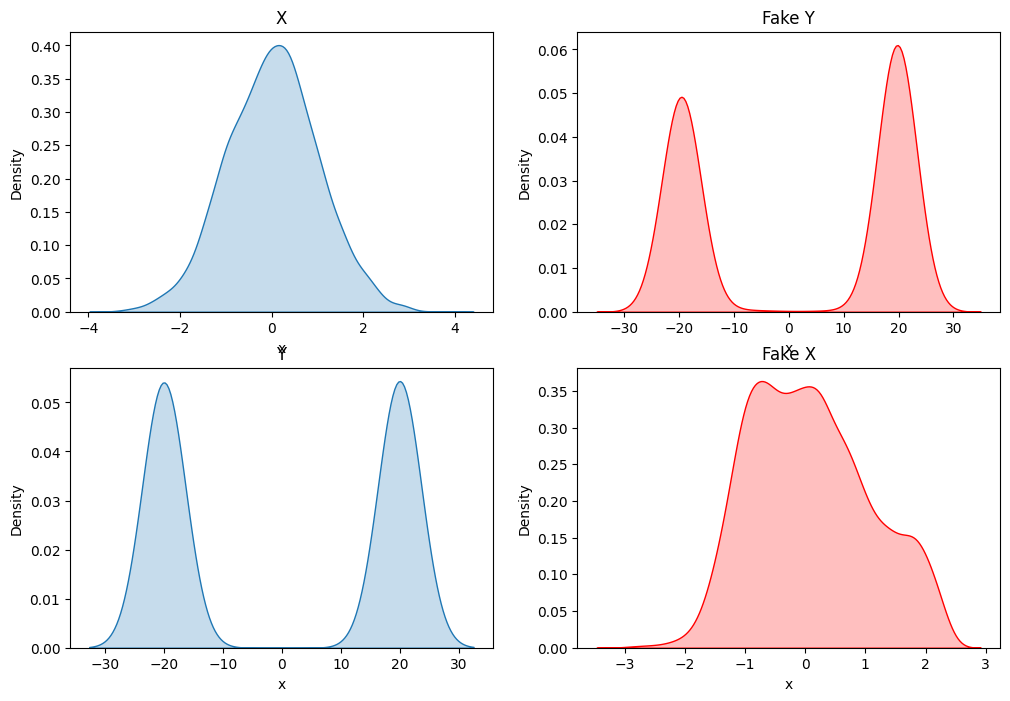

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

# Two variate

In [2]:
batch_size = 1024

moons_set = MoonsDataset(4096)
circles_set = CirclesDataset(4096)

moons = DataLoader(moons_set, batch_size=batch_size, shuffle=True)
circles = DataLoader(circles_set, batch_size=batch_size, shuffle=True)

In [3]:
# Models parameters
data_dim = 2
hidden_dims = [256, 256, 256]

discriminator_backward1 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward1 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)


conditional_p1 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q1 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p1,
    conditional_q1,
    discriminator_backward1,
    discriminator_forward1,
    gamma=1,
    lr_disc={'forward': 1e-6, 'backward': 1e-6},
    lr_gen={'forward': 1e-6, 'backward': 1e-6}, 
    device=device
)

losses1 = trainer.train(300, circles, moons, inner_steps=60)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.16921, disc_b_fixed: 0.47684, disc_b_training: -0.16854
Backward cond_p: 0.17070, disc_b_fixed: 0.47418, disc_b_training: -0.16934
Backward cond_p: 0.16924, disc_b_fixed: 0.47136, disc_b_training: -0.17019
Backward cond_p: 0.17162, disc_b_fixed: 0.46930, disc_b_training: -0.17168
Backward cond_p: 0.17395, disc_b_fixed: 0.46963, disc_b_training: -0.17259
Backward cond_p: 0.17337, disc_b_fixed: 0.46849, disc_b_training: -0.17529
Backward cond_p: 0.17374, disc_b_fixed: 0.46613, disc_b_training: -0.17472
Backward cond_p: 0.17619, disc_b_fixed: 0.46453, disc_b_training: -0.17704
Backward cond_p: 0.17707, disc_b_fixed: 0.46382, disc_b_training: -0.17625
Backward cond_p: 0.17805, disc_b_fixed: 0.46378, disc_b_training: -0.17903
Backward cond_p: 0.18129, disc_b_fixed: 0.46294, disc_b_training: -0.18058
Backward cond_p: 0.18174, disc_b_fixed: 0.46240, disc_b_training: -0.18300
Backward cond_p: 0.18235, disc_b_fixed: 0.46038, disc_b_training: -0.18248
B

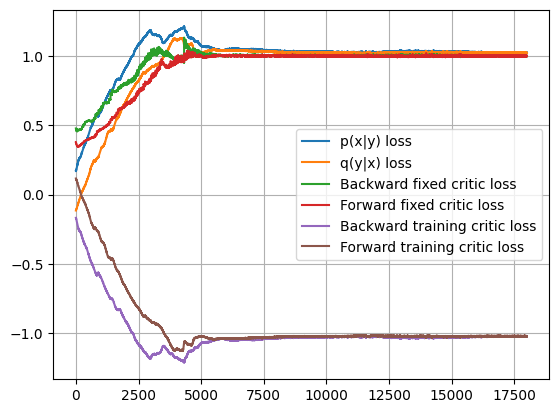

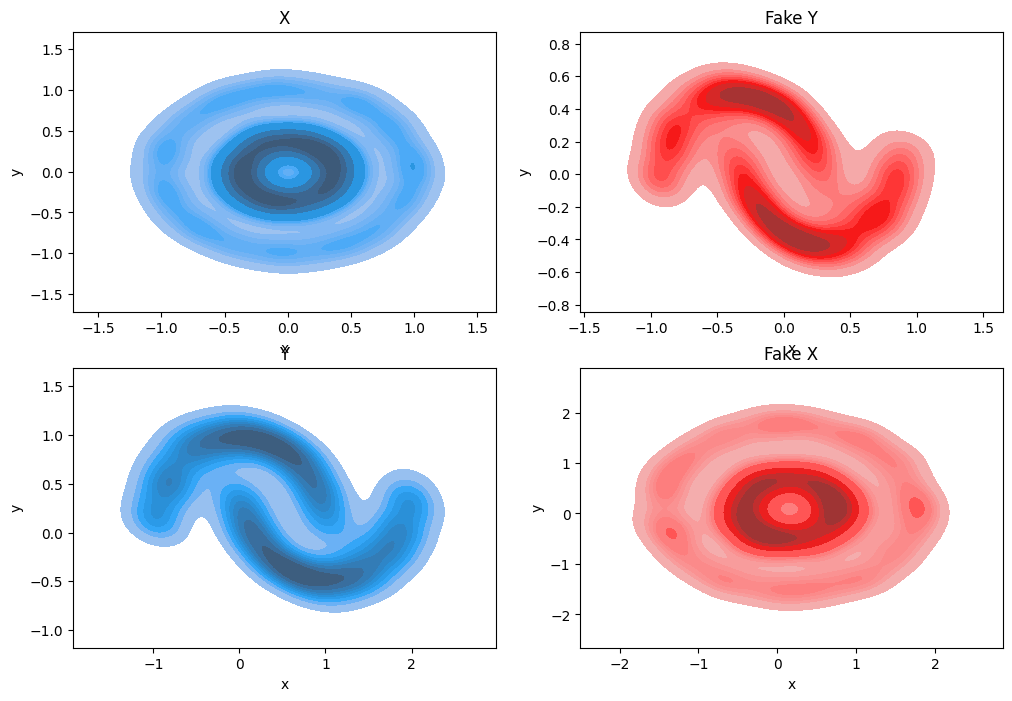

In [4]:
conditional_q1.to('cpu')
conditional_p1.to('cpu')

visualize_losses(losses1, trainer.loss_titles)
visualize_sb(conditional_p1, conditional_q1, circles_set, moons_set, num_samples=len(circles_set))

In [5]:
# Models parameters
data_dim = 2
hidden_dims = [256, 256, 256]

discriminator_backward2 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward2 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)


conditional_p2 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q2 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p2,
    conditional_q2,
    discriminator_backward2,
    discriminator_forward2,
    gamma=0.01,
    lr_disc={'forward': 1e-6, 'backward': 1e-6},
    lr_gen={'forward': 1e-6, 'backward': 1e-6}, 
    device=device
)

losses2 = trainer.train(300, circles, moons, inner_steps=60)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.09903, disc_b_fixed: 0.35808, disc_b_training: 0.09885
Backward cond_p: -0.09802, disc_b_fixed: 0.35594, disc_b_training: 0.09799
Backward cond_p: -0.09745, disc_b_fixed: 0.35406, disc_b_training: 0.09655
Backward cond_p: -0.09669, disc_b_fixed: 0.35231, disc_b_training: 0.09498
Backward cond_p: -0.09463, disc_b_fixed: 0.35093, disc_b_training: 0.09548
Backward cond_p: -0.09436, disc_b_fixed: 0.34935, disc_b_training: 0.09423
Backward cond_p: -0.09349, disc_b_fixed: 0.34803, disc_b_training: 0.09301
Backward cond_p: -0.09255, disc_b_fixed: 0.34676, disc_b_training: 0.09246
Backward cond_p: -0.08967, disc_b_fixed: 0.34565, disc_b_training: 0.09020
Backward cond_p: -0.09048, disc_b_fixed: 0.34456, disc_b_training: 0.09068
Backward cond_p: -0.08863, disc_b_fixed: 0.34374, disc_b_training: 0.08911
Backward cond_p: -0.08729, disc_b_fixed: 0.34282, disc_b_training: 0.08708
Backward cond_p: -0.08615, disc_b_fixed: 0.34209, disc_b_training: 0.08791
B

Backward cond_p: -0.08264, disc_b_fixed: 0.34005, disc_b_training: 0.08341
Backward cond_p: -0.08195, disc_b_fixed: 0.33955, disc_b_training: 0.08136
Backward cond_p: -0.08081, disc_b_fixed: 0.33897, disc_b_training: 0.08017
Backward cond_p: -0.07792, disc_b_fixed: 0.33856, disc_b_training: 0.07899
Backward cond_p: -0.07809, disc_b_fixed: 0.33800, disc_b_training: 0.07743
Backward cond_p: -0.07691, disc_b_fixed: 0.33762, disc_b_training: 0.07653
Backward cond_p: -0.07536, disc_b_fixed: 0.33738, disc_b_training: 0.07593
Backward cond_p: -0.07401, disc_b_fixed: 0.33697, disc_b_training: 0.07369
Backward cond_p: -0.07185, disc_b_fixed: 0.33654, disc_b_training: 0.07288
Backward cond_p: -0.07050, disc_b_fixed: 0.33634, disc_b_training: 0.07167
Backward cond_p: -0.06970, disc_b_fixed: 0.33606, disc_b_training: 0.06939
Backward cond_p: -0.06903, disc_b_fixed: 0.33584, disc_b_training: 0.06816
Backward cond_p: -0.06624, disc_b_fixed: 0.33554, disc_b_training: 0.06678
Backward cond_p: -0.06639

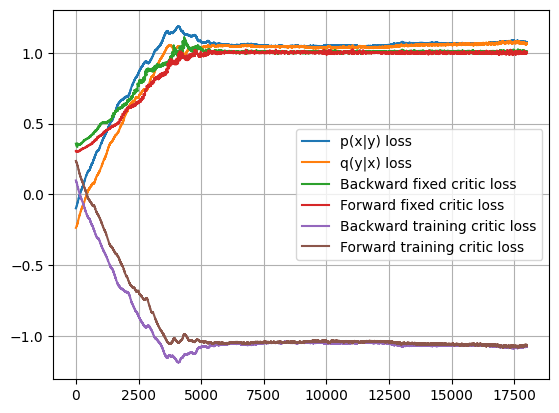

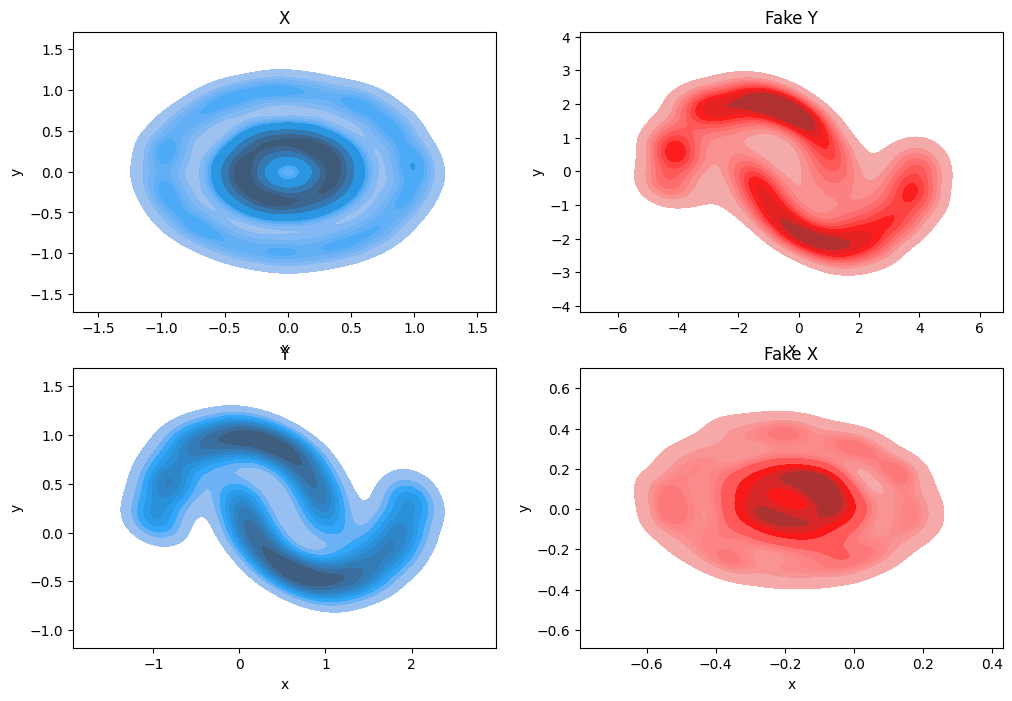

In [6]:
conditional_q2.to('cpu')
conditional_p2.to('cpu')

visualize_losses(losses2, trainer.loss_titles)
visualize_sb(conditional_p2, conditional_q2, circles_set, moons_set, num_samples=len(circles_set))

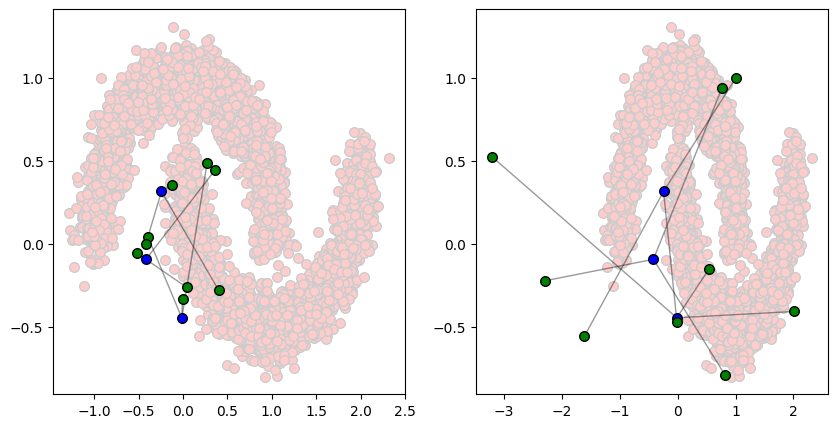

In [7]:
visualize_gamma(conditional_q1, conditional_q2, circles_set, moons_set)

In [8]:
# Models parameters
data_dim = 2
hidden_dims = [256, 256, 256]

discriminator_backward3 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward3 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)


conditional_p3 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q3 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p3,
    conditional_q3,
    discriminator_backward3,
    discriminator_forward3,
    gamma=1,
    lr_disc={'forward': 1e-6, 'backward': 1e-6},
    lr_gen={'forward': 1e-6, 'backward': 1e-6}, 
    device=device
)

losses3 = trainer.train(400, circles, moons, inner_steps=100)

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.15018, disc_b_fixed: 0.34195, disc_b_training: 0.14963
Backward cond_p: -0.14803, disc_b_fixed: 0.34201, disc_b_training: 0.15072
Backward cond_p: -0.14755, disc_b_fixed: 0.34121, disc_b_training: 0.14730
Backward cond_p: -0.14646, disc_b_fixed: 0.34093, disc_b_training: 0.14570
Backward cond_p: -0.14342, disc_b_fixed: 0.34011, disc_b_training: 0.14471
Backward cond_p: -0.14383, disc_b_fixed: 0.33987, disc_b_training: 0.14299
Backward cond_p: -0.14167, disc_b_fixed: 0.33998, disc_b_training: 0.14109
Backward cond_p: -0.14116, disc_b_fixed: 0.34003, disc_b_training: 0.14093
Backward cond_p: -0.13780, disc_b_fixed: 0.34020, disc_b_training: 0.13770
Backward cond_p: -0.13726, disc_b_fixed: 0.33791, disc_b_training: 0.13776
Backward cond_p: -0.13619, disc_b_fixed: 0.33891, disc_b_training: 0.13454
Backward cond_p: -0.13491, disc_b_fixed: 0.33860, disc_b_training: 0.13519
Backward cond_p: -0.13339, disc_b_fixed: 0.33824, disc_b_training: 0.13293
B

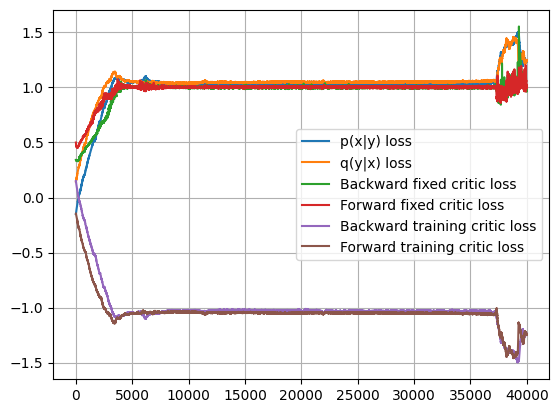

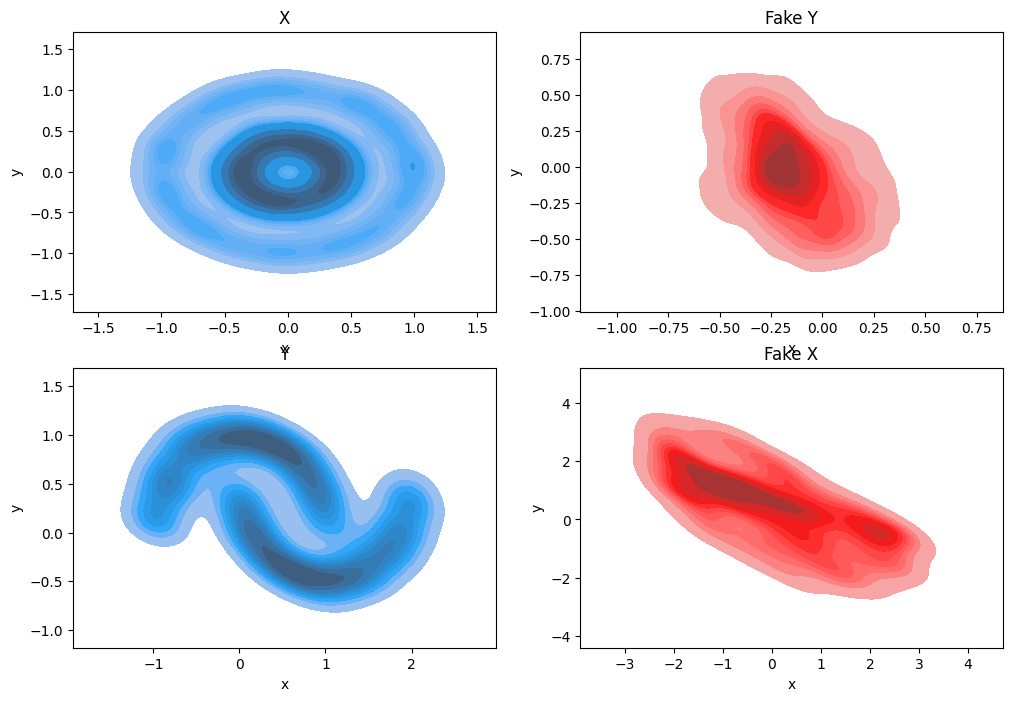

In [9]:
conditional_q3.to('cpu')
conditional_p3.to('cpu')

visualize_losses(losses3, trainer.loss_titles)
visualize_sb(conditional_p3, conditional_q3, circles_set, moons_set, num_samples=len(circles_set))

# Images: Letters $\rightarrow$ Digits

In [19]:
hyper_params = {
    'data': {
        'batch_size': 4096,
        'dataset': 'Letters <-> Digits'
    },
    'train': {
        'gamma': 1,
        'lr_disc': {'forward': 1e-6, 'backward': 1e-6},
        'lr_gen': {'forward': 1e-6, 'backward': 1e-6},
        'epochs': 400,
        'inner_steps': 60,
    }
}
batch_size = hyper_params['data']['batch_size']

letters_set = LettersDataset('../data/emnist/emnist-letters-train.csv')
digits_set = DigitsDataset('../data/emnist/emnist-mnist-train.csv')

letters = DataLoader(letters_set, batch_size=batch_size, shuffle=True)
digits = DataLoader(digits_set, batch_size=batch_size, shuffle=True)

In [20]:
wandb.login()
wandb.init(
    project="adversarial-sb",
    notes="EMNIST",
    config=hyper_params
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [23]:
discriminator_backward = Critic(hidden_dims=[256, 128, 64]).to(device)
discriminator_forward = Critic(hidden_dims=[256, 128, 64]).to(device)

conditional_p = Conditional(hidden_dims=[256, 128, 256]).to(device)
conditional_q = Conditional(hidden_dims=[256, 128, 256]).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    gamma=hyper_params['train']['gamma'],
    lr_disc=hyper_params['train']['lr_disc'],
    lr_gen=hyper_params['train']['lr_gen'],
    device=device
)

losses = trainer.train(hyper_params['train']['epochs'], letters, digits, inner_steps=hyper_params['train']['inner_steps'])

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.08568, disc_b_fixed: 0.36049, disc_b_training: 0.08550
Backward cond_p: -0.08354, disc_b_fixed: 0.35966, disc_b_training: 0.08360
Backward cond_p: -0.08114, disc_b_fixed: 0.35884, disc_b_training: 0.08143
Backward cond_p: -0.07922, disc_b_fixed: 0.35821, disc_b_training: 0.07913
Backward cond_p: -0.07708, disc_b_fixed: 0.35789, disc_b_training: 0.07714
Backward cond_p: -0.07525, disc_b_fixed: 0.35732, disc_b_training: 0.07502


In [22]:
wandb.finish()

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

conditional_q.eval()
conditional_p.eval()

visualize_losses(losses, trainer.loss_titles, inner_steps=hyper_params['train']['inner_steps'])
visualize_sb_images(conditional_p, conditional_q, letters_set, digits_set, x_title='Letter', y_title='Digit', num_samples=16)

NameError: name 'losses' is not defined

In [ ]:
torch.save(conditional_p.state_dict(), '../models/emnist3_conditional_p.pt')
torch.save(conditional_q.state_dict(), '../models/emnist3_conditional_q.pt')

In [ ]:
conditional_p = Conditional(hidden_dims=[256, 256])
conditional_p.load_state_dict(torch.load('../models/emnist3_conditional_p.pt'))

conditional_q = Conditional(hidden_dims=[256, 256])
conditional_q.load_state_dict(torch.load('../models/emnist3_conditional_q.pt'))

<All keys matched successfully>